In [2]:
import numpy as np
import os
import matlab.engine
import matplotlib.pyplot as plt
from Camera_util import parse_video, parse_mean_video
import pandas as pd
from natsort import natsorted
import time
import Camera_util 
import importlib
import pickle
import scipy.io
import heapq
from collections.abc import Iterable

Analyzing 200FPS_6hz_0NDF.mat
Observed FPS: 256.001213110562
R2: 0.9977257946486847
Amplitude: 0.46951224759252164
Analyzing 200FPS_50hz_0NDF.mat
Observed FPS: 256.0009284384376
R2: 0.8509779163298518
Amplitude: 0.0601111787295925
Analyzing 200FPS_0.5hz_0NDF.mat
Observed FPS: 256.052412631902
R2: 0.999976574547079
Amplitude: 0.4892031944122274
Analyzing 200FPS_100hz_0NDF.mat
Observed FPS: 256.0148217034675
R2: 0.003971189071498371
Amplitude: 0.0028488358955671483
Analyzing 200FPS_3hz_0NDF.mat
Observed FPS: 256.0007764050038
R2: 0.9994203727402516
Amplitude: 0.4838360469475169
Analyzing 200FPS_1hz_0NDF.mat
Observed FPS: 256.0012933977345
R2: 0.9999055440092793
Amplitude: 0.489559800984846
Analyzing 200FPS_12hz_0NDF.mat
Observed FPS: 256.0000531691843
R2: 0.9910522911026672
Amplitude: 0.42285868644488406
Analyzing 200FPS_25hz_0NDF.mat
Observed FPS: 256.00004437680104
R2: 0.9616093110366747
Amplitude: 0.30835883441197615
Analyzing 200FPS_0.25hz_0NDF.mat
Observed FPS: 256.01297840416527
R2

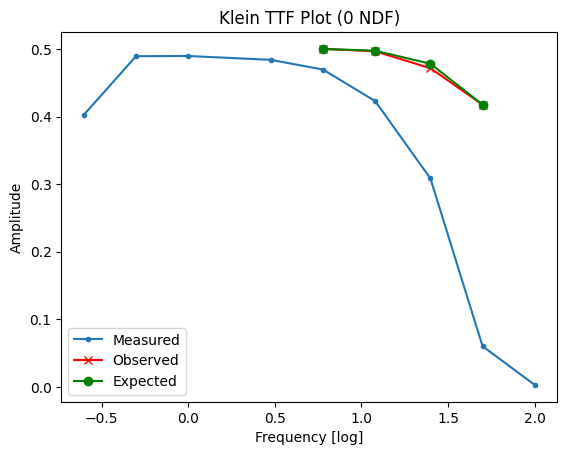

In [4]:
importlib.reload(Camera_util)
recordings_dir = '/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_data/recordings'
experiment_filename = '200FPS'
Camera_util.generate_klein_ttf(recordings_dir, experiment_filename)